In [1]:
import time

# data processing library
import numpy as np
import pandas as pd
from functools import reduce
import collections

# data visualization library  
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")


# Background

Boehringer Ingelheim has been working on a multi channel customer engagement approach as part of their strategy. 

As such, email communication has been identified as a viable channel in which to communicate with physicians.

As customer centricity is a focus for BI, the online communication should be tailored to the physician‘s preferences and requirements.

BI has been working with physicians to obtain their consent to receiving communication from the company via email. 

This is mainly done by having the customer facing team ask the physician for their consent during face to face visits.

The Brand Team has created compliance approved promotional materials for online communcation. 

A campaign cycle has been completed using a mix of face to face and email communication and data has been collected to look at the email activity of physicians.


# Task

In the data provided to you, there is record of the email communication sent to physicians who have opted in. 

As email communication is regulated by law, BI can only contact physicians via this channel if an opt in is available.

You will also find the categorization of email addresses of customers in private practice or in a clinic, which indicates the preferred email address of the physician with which they would like BI to use.

Based on the needs of the Brand Team, analyze the data and prepare a management presentation to provide recommendations for optimizing the email communication approach including recommendations on how to measure the success of subsequent email campaigns.

Your presentation should be no longer than 15 minutes. The audience will be a mixed group of brand team members including analysts.

You are welcome to use any presentation medium.



# Fundamentals

## Email Consent under GDPR

https://www.litmus.com/blog/5-things-you-must-know-about-email-consent-under-gdpr/

https://www.litmus.com/blog/remember-when-they-said-gdpr-would-kill-email-it-didnt/


## Doctor's preferences and requirements

https://pubmed.ncbi.nlm.nih.gov/23529716/

https://physicianspreferencerx.com/5-myths/

https://www.researchgate.net/publication/322374897_Physician_preference_items_what_factors_matter_to_surgeons_Does_the_vendor_matter


## Measure the success of subsequent email campaigns.

https://kevy.co/marketing/email-marketing/9-relevant-kpis-for-email-campaigns/

https://www.superoffice.com/blog/measuring-the-effectiveness-of-email-marketing/

https://databox.com/email-marketing-metrics

https://emarsys.com/learn/blog/ultimate-guide-measuring-email-marketing-success/


# Read Data

## Description of the fields

- HCP_ID
    - HCP0001018487

    - Physician's ID (at least 1 record per person, multiple records for promotions and multiple emails)

    - (diverse)


- ACCOUNT_TYPE
    - Account type

    - Specifies the account type of the customer's email address.
    
    - Private, Klinic (clinic), Nicht eindeutig (ambiguous)
    
 
- EMAIL_ID
    - ID1
    - Email ID that can be used to uniquely identify an email. The same emails have the same ID
    -  ID1, ID2,....ID120


- DELIVERY_STATUS
    - sent
    - Delivery Status of email
    - Sent, opened, clicked, failed


- PRODUKT
    - Produkt1
    - Product Name
    - Produkt 1, Produkt 2,...Produkt 6
 
 
- DATUM_ID
    - 20190109
    - Email activity date, format YYYYMMDD (can be NULL)
    - (diverse)
  
  
- DAY
    - 09.01.2019 21:00
    - Date and time of the email activity, format DD.MM.YYYY HH: MM (can be NULL) The times are always rounded to the hour
    - (diverse)






In [123]:
df_account = pd.read_excel('Account_Cluster.xlsx')


In [124]:
def get_hcp_id(row):
    return row['HCP_ID;ACCOUNT_TYPE'].split(';')[0]

def get_account_type(row):
    return row['HCP_ID;ACCOUNT_TYPE'].split(';')[1]

df_account['HCP_ID'] = df_account.apply(get_hcp_id, axis=1)
df_account['ACCOUNT_TYPE'] = df_account.apply(get_account_type, axis=1)
df_account.drop(columns=['HCP_ID;ACCOUNT_TYPE'], inplace=True)


In [125]:
df_account.head()


,HCP_ID,ACCOUNT_TYPE
0,HCP0001018487,private
1,HCP0001006058,private
2,HCP0001013999,private
3,HCP0001002071,private
4,HCP0001008572,private


In [126]:
df_account.shape

(17045, 2)

In [127]:
df_email_performance = pd.read_csv('EMail_Performance.csv', delimiter=';')


In [128]:
df_email_performance['DATE'] = pd.to_datetime(df_email_performance['DATUM_ID'], format="%Y%m%d")
df_email_performance['DATE_TIME'] = pd.to_datetime(df_email_performance['DAY'], format="%d.%m.%Y %H:%M")

# df_email_performance['DATE_TIME'].dt.hour.unique()


In [129]:
df_email_performance.head()


,HCP_ID,EMAIL_ID,DELIVERY_STATUS,PRODUKT,DATUM_ID,DAY,DATE,DATE_TIME
0,HCP0001001023,ID1,sent,Produkt 1,20190109,09.01.2019 21:00,2019-01-09,2019-01-09 21:00:00
1,HCP0001001024,ID2,opened,Produkt 1,20181024,24.10.2018 01:00,2018-10-24,2018-10-24 01:00:00
2,HCP0001001025,ID3,sent,Produkt 2,20181130,30.11.2018 13:00,2018-11-30,2018-11-30 13:00:00
3,HCP0001001026,ID4,opened,Produkt 3,20181119,19.11.2018 14:00,2018-11-19,2018-11-19 14:00:00
4,HCP0001001027,ID5,opened,Produkt 4,20181213,13.12.2018 14:00,2018-12-13,2018-12-13 14:00:00


In [130]:
df_email_performance.shape


(359777, 8)

In [131]:
len(df_email_performance['HCP_ID'].unique())


18841

In [132]:
len(df_account['HCP_ID'].unique())


17045

In [133]:
df = pd.merge(df_account, df_email_performance, on='HCP_ID', how='right')


In [134]:
df.shape


(359777, 9)

In [135]:
df.head()


,HCP_ID,ACCOUNT_TYPE,EMAIL_ID,DELIVERY_STATUS,PRODUKT,DATUM_ID,DAY,DATE,DATE_TIME
0,HCP0001018487,private,ID51,sent,Produkt 1,20170307,07.03.2017 11:00,2017-03-07,2017-03-07 11:00:00
1,HCP0001006058,private,ID11,sent,Produkt 6,20180516,16.05.2018 14:00,2018-05-16,2018-05-16 14:00:00
2,HCP0001006058,private,ID26,opened,Produkt 4,20181212,12.12.2018 15:00,2018-12-12,2018-12-12 15:00:00
3,HCP0001006058,private,ID26,opened,Produkt 4,20181213,13.12.2018 17:00,2018-12-13,2018-12-13 17:00:00
4,HCP0001006058,private,ID16,opened,Produkt 5,20181113,13.11.2018 19:00,2018-11-13,2018-11-13 19:00:00


# Exploratory Data Analysis (EDA)



In [136]:
def plot_pie_bar(df, col, title=''):
    f,ax=plt.subplots(1, 2, figsize=(20, 8))
    
    df[col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(col)
    ax[0].set_ylabel('')
    
    sns.countplot(col, order = df[col].value_counts().index, data=df, ax=ax[1])
    ax[1].set_title(col)
    
    plt.title(title)
    plt.show()
    
    return 


In [137]:
df.columns


Index(['HCP_ID', 'ACCOUNT_TYPE', 'EMAIL_ID', 'DELIVERY_STATUS', 'PRODUKT',
       'DATUM_ID', 'DAY', 'DATE', 'DATE_TIME'],
      dtype='object')

## ACCOUNT_TYPE


In [139]:
#ax = sns.countplot(df['ACCOUNT_TYPE'], label="Count")
#df['ACCOUNT_TYPE'].value_counts().sort_index().plot(kind='bar', figsize=(10, 3))


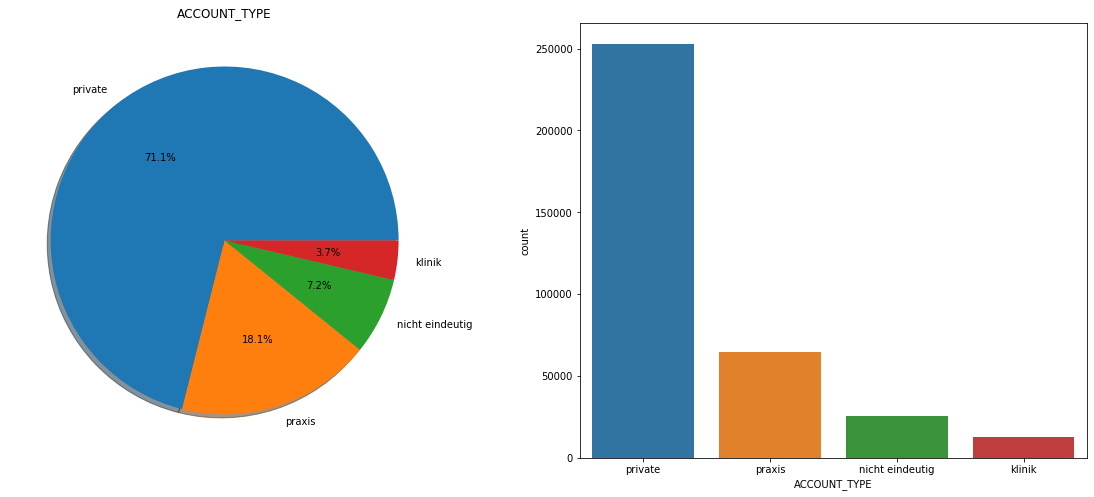

In [140]:
plot_pie_bar(df, 'ACCOUNT_TYPE')


## DELIVERY_STATUS


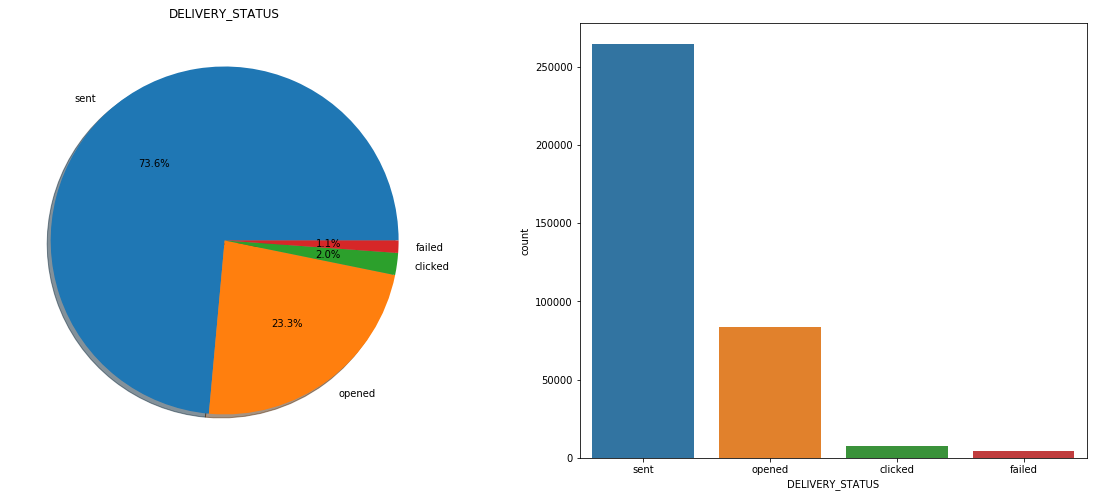

In [141]:
plot_pie_bar(df, 'DELIVERY_STATUS')


## PRODUKT


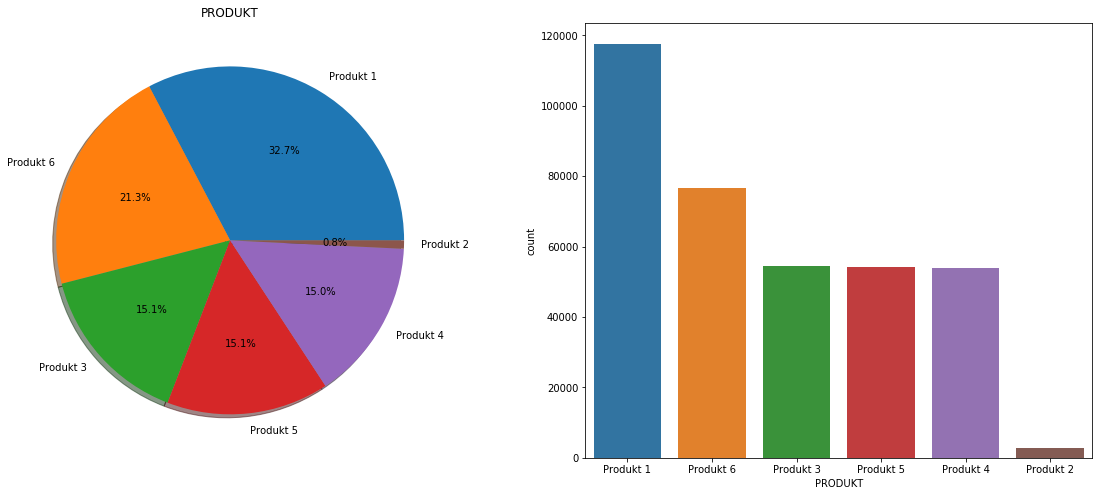

In [143]:
plot_pie_bar(df, 'PRODUKT')


## DATE_TIME

In [144]:
df['TIME'] = df['DATE_TIME'].dt.hour


In [145]:
df.head()

,HCP_ID,ACCOUNT_TYPE,EMAIL_ID,DELIVERY_STATUS,PRODUKT,DATUM_ID,DAY,DATE,DATE_TIME,TIME
0,HCP0001018487,private,ID51,sent,Produkt 1,20170307,07.03.2017 11:00,2017-03-07,2017-03-07 11:00:00,11
1,HCP0001006058,private,ID11,sent,Produkt 6,20180516,16.05.2018 14:00,2018-05-16,2018-05-16 14:00:00,14
2,HCP0001006058,private,ID26,opened,Produkt 4,20181212,12.12.2018 15:00,2018-12-12,2018-12-12 15:00:00,15
3,HCP0001006058,private,ID26,opened,Produkt 4,20181213,13.12.2018 17:00,2018-12-13,2018-12-13 17:00:00,17
4,HCP0001006058,private,ID16,opened,Produkt 5,20181113,13.11.2018 19:00,2018-11-13,2018-11-13 19:00:00,19


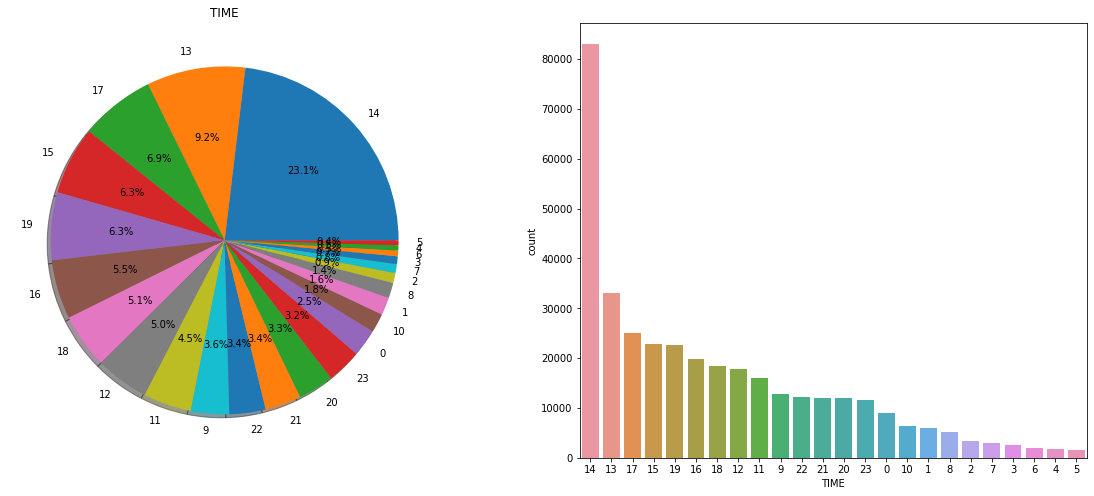

In [146]:
plot_pie_bar(df, 'TIME')


In [147]:
def get_time_group(time):
    if 0 <= time <= 7:
        return '0 - 7'
    elif 7 < time <= 12:
        return '7 - 12'
    elif 12 < time <= 13:
        return '12 - 13'
    elif 13 < time <= 18:
        return '13 - 18'
    else:
        return '18 - 0'
    

In [148]:
df['TIME_GROUP'] = df['TIME'].apply(get_time_group)


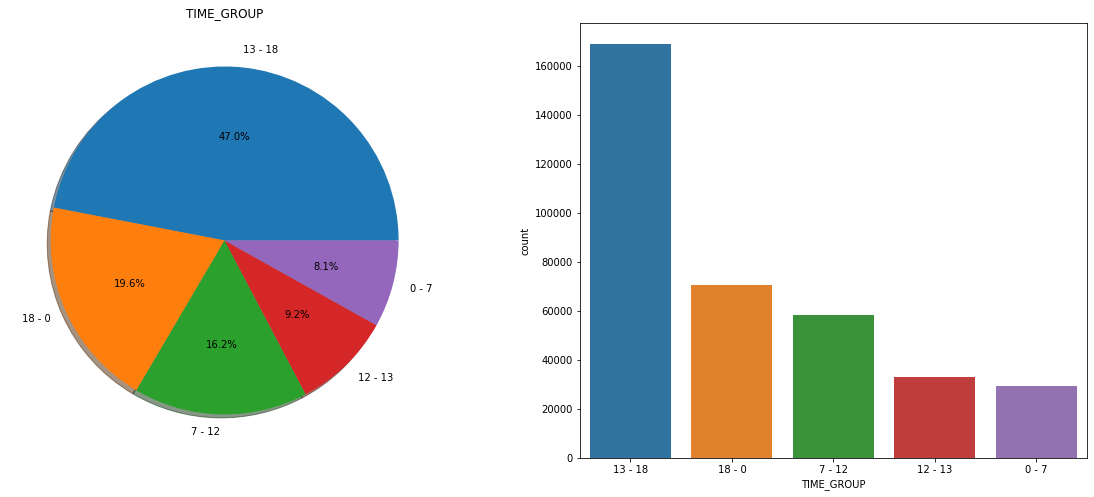

In [149]:
plot_pie_bar(df, 'TIME_GROUP')


In [150]:
df['YEAR'] = df['DATE_TIME'].dt.year
df['MONTH'] = df['DATE_TIME'].dt.month
df['DAY_OF_WEEK'] = df['DATE_TIME'].dt.dayofweek


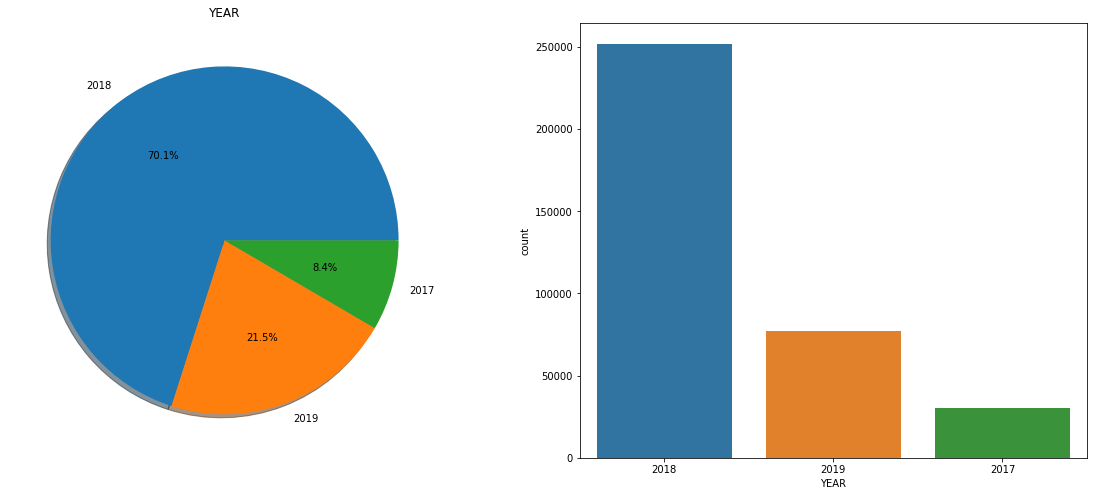

In [151]:
plot_pie_bar(df, 'YEAR')


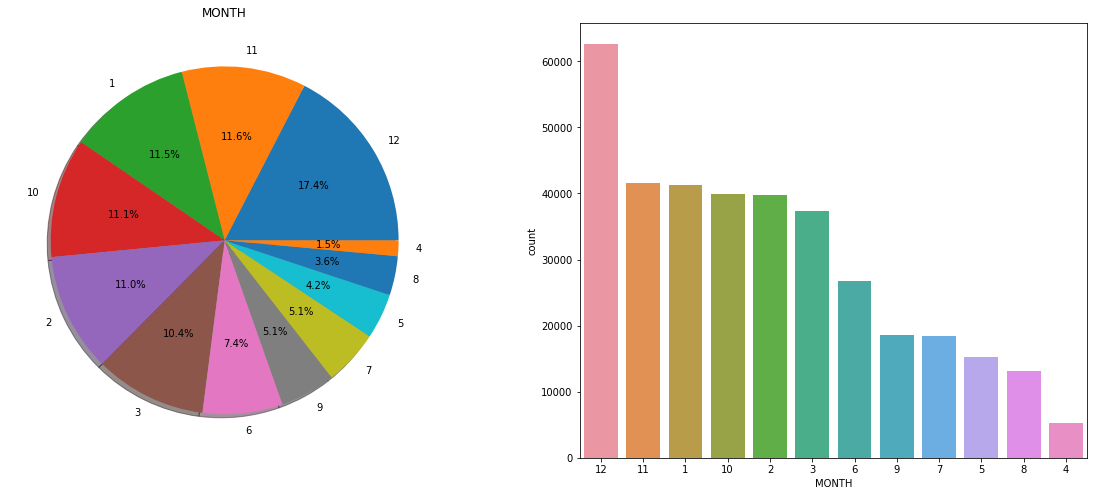

In [152]:
plot_pie_bar(df, 'MONTH')


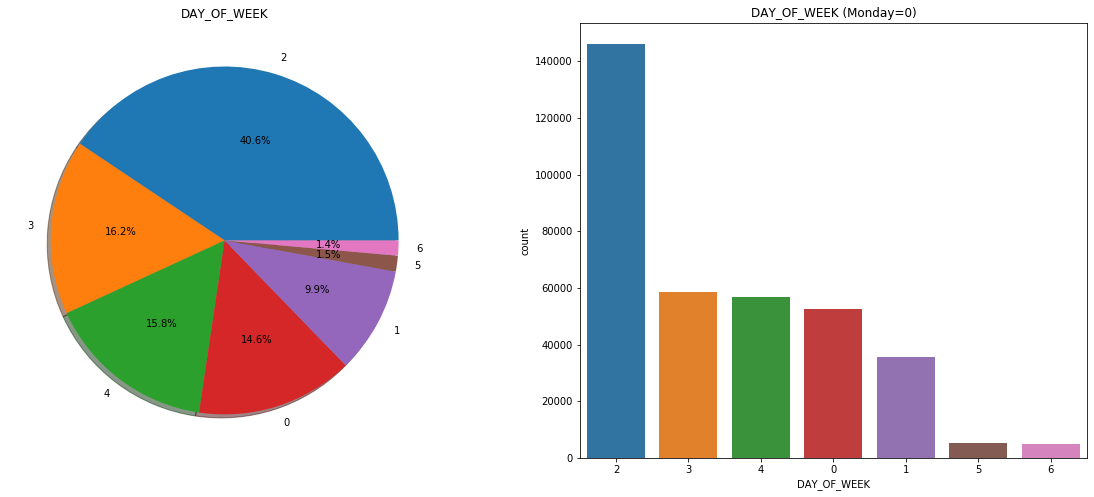

In [153]:
plot_pie_bar(df, 'DAY_OF_WEEK', title='DAY_OF_WEEK (Monday=0)')


## HCP_ID

- HCP0001018487

- Physician's ID (at least 1 record per person, multiple records for promotions and multiple emails)

- (diverse)


In [98]:
len(df['HCP_ID'].unique())


18841

In [106]:
group_email = df.groupby(['HCP_ID'])['EMAIL_ID'].apply(set).reset_index(name='set_EMAIL_ID')


In [107]:
group_email


,HCP_ID,set_EMAIL_ID
0,HCP0001001023,"{ID6, ID1, ID2, ID35, ID26, ID50, ID7, ID14, I..."
1,HCP0001001024,"{ID6, ID1, ID5, ID2, ID35, ID12, ID50, ID7, ID..."
2,HCP0001001025,"{ID8, ID3}"
3,HCP0001001026,"{ID46, ID32, ID4, ID33, ID59, ID83}"
4,HCP0001001027,"{ID43, ID23, ID22, ID6, ID15, ID5, ID2, ID58, ..."
...,...,...
18836,HCP0001019859,{ID11}
18837,HCP0001019860,{ID7}
18838,HCP0001019861,{ID11}
18839,HCP0001019862,{ID63}


In [108]:
def get_nb_emails(row):
    return len(row['set_EMAIL_ID'])
    
group_email['NB_EMAILS'] = group_email.apply(get_nb_emails, axis=1)
    

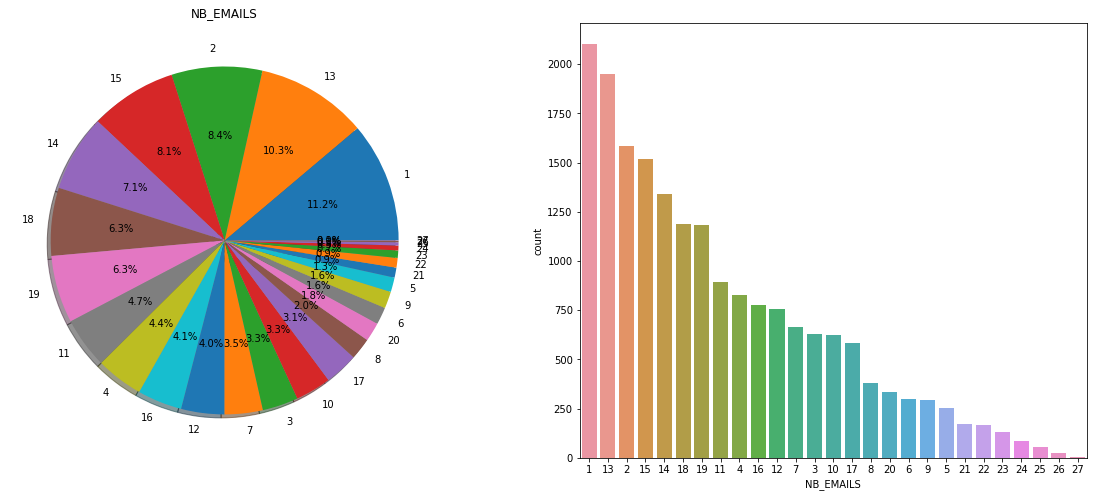

In [109]:
plot_pie_bar(group_email, 'NB_EMAILS')


## EMAIL_ID
    - ID1
    - Email ID that can be used to uniquely identify an email. The same emails have the same ID
    - ID1, ID2,....ID120



In [168]:
len(df['EMAIL_ID'].unique())


120

In [169]:
df.columns


Index(['HCP_ID', 'ACCOUNT_TYPE', 'EMAIL_ID', 'DELIVERY_STATUS', 'PRODUKT',
       'DATUM_ID', 'DAY', 'DATE', 'DATE_TIME', 'TIME', 'TIME_GROUP', 'YEAR',
       'MONTH', 'DAY_OF_WEEK'],
      dtype='object')

In [170]:
def get_nb_hcp_id(row):
    return len(row['set_HCP_ID'])


In [171]:
grouped_email = df.groupby(['EMAIL_ID'])['HCP_ID'].apply(set).reset_index(name='set_HCP_ID')

grouped_email['NB_HCP_ID'] = grouped_email.apply(get_nb_hcp_id, axis=1)

grouped_email.sort_values(by='NB_HCP_ID', ascending=False, inplace=True)


In [196]:
grouped_email


,EMAIL_ID,set_HCP_ID,NB_HCP_ID
12,ID11,"{HCP0001003173, HCP0001016270, HCP0001005062, ...",15052
98,ID8,"{HCP0001003173, HCP0001005062, HCP0001006981, ...",14608
76,ID6,"{HCP0001003173, HCP0001005062, HCP0001006981, ...",12527
0,ID1,"{HCP0001003173, HCP0001005062, HCP0001006981, ...",10018
28,ID16,"{HCP0001003173, HCP0001005062, HCP0001006981, ...",9372
...,...,...,...
19,ID116,"{HCP0001015678, HCP0001011653, HCP0001018555, ...",5
22,ID119,{HCP0001004131},1
20,ID117,{HCP0001012150},1
21,ID118,{HCP0001004131},1


In [174]:
grouped_email['NB_HCP_ID'].unique()


array([15052, 14608, 12527, 10018,  9372,  7707,  7674,  7522,  6761,
        5028,  5027,  4743,  4592,  3783,  3684,  3391,  3360,  3353,
        3326,  3300,  2341,  2337,  2326,  2325,  2317,  2308,  2290,
        2163,  2051,  1988,  1979,  1967,  1950,  1922,  1851,  1616,
        1600,  1382,  1368,  1046,  1042,  1035,  1001,   988,   935,
         891,   890,   885,   867,   794,   769,   655,   650,   588,
         535,   528,   517,   515,   513,   503,   499,   498,   494,
         489,   465,   460,   459,   457,   456,   452,   436,   434,
         429,   427,   424,   421,   398,   335,   333,   302,   299,
         254,   248,   243,   201,   199,   189,   187,   173,   171,
         167,   155,   139,   122,   121,   115,   114,   113,   108,
          73,    68,    64,    63,    47,    43,    25,    22,    20,
           8,     5,     1])

In [197]:
grouped_email[grouped_email['EMAIL_ID'] == 'ID11']


,EMAIL_ID,set_HCP_ID,NB_HCP_ID
12,ID11,"{HCP0001003173, HCP0001016270, HCP0001005062, ...",15052


In [198]:
grouped_email[grouped_email['EMAIL_ID'] == 'ID3']


,EMAIL_ID,set_HCP_ID,NB_HCP_ID
43,ID3,"{HCP0001011143, HCP0001011209, HCP0001014347, ...",1922


## How many time a product is mentioned in an email


In [122]:
df['PRODUKT'].unique()


array(['Produkt 1', 'Produkt 6', 'Produkt 4', 'Produkt 5', 'Produkt 3',
       'Produkt 2'], dtype=object)

In [178]:
def get_nb_emails(row):
    return len(row['set_EMAIL_ID'])

group_product = df.groupby(['PRODUKT'])['EMAIL_ID'].apply(set).reset_index(name='set_EMAIL_ID')

group_product['NB_EMAIL_ID'] = group_product.apply(get_nb_emails, axis=1)

group_product.sort_values(by='NB_EMAIL_ID', ascending=False, inplace=True)



In [179]:
group_product

,PRODUKT,set_EMAIL_ID,NB_EMAIL_ID
4,Produkt 5,"{ID28, ID113, ID42, ID72, ID56, ID29, ID60, ID...",37
0,Produkt 1,"{ID44, ID34, ID57, ID2, ID99, ID13, ID98, ID65...",33
3,Produkt 4,"{ID76, ID87, ID109, ID64, ID67, ID85, ID84, ID...",26
2,Produkt 3,"{ID46, ID6, ID108, ID32, ID4, ID91, ID24, ID41...",15
5,Produkt 6,"{ID117, ID96, ID106, ID55, ID103, ID11, ID51, ...",12
1,Produkt 2,{ID3},1


In [180]:
def get_nb_hcp(row):
    return len(row['set_HCP_ID'])

group_product = df.groupby(['PRODUKT'])['HCP_ID'].apply(set).reset_index(name='set_HCP_ID')

group_product['NB_HCP_ID'] = group_product.apply(get_nb_hcp, axis=1)

group_product.sort_values(by='NB_HCP_ID', ascending=False, inplace=True)


In [181]:
group_product


,PRODUKT,set_HCP_ID,NB_HCP_ID
2,Produkt 3,"{HCP0001003173, HCP0001005062, HCP0001006981, ...",15512
0,Produkt 1,"{HCP0001003173, HCP0001016270, HCP0001005062, ...",15211
4,Produkt 5,"{HCP0001003173, HCP0001005062, HCP0001006981, ...",13203
5,Produkt 6,"{HCP0001003173, HCP0001016270, HCP0001005062, ...",13124
3,Produkt 4,"{HCP0001003173, HCP0001005062, HCP0001006981, ...",12569
1,Produkt 2,"{HCP0001011143, HCP0001011209, HCP0001014347, ...",1922


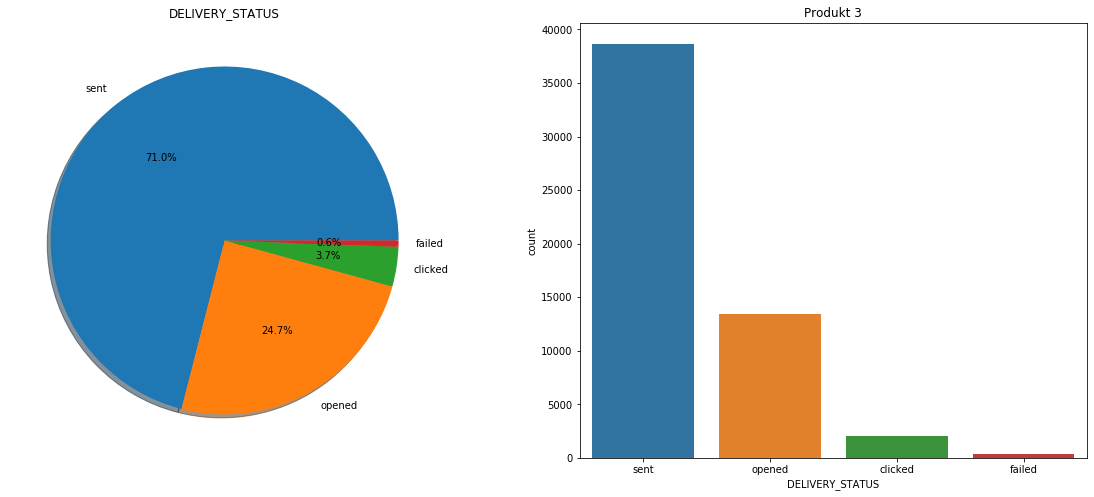

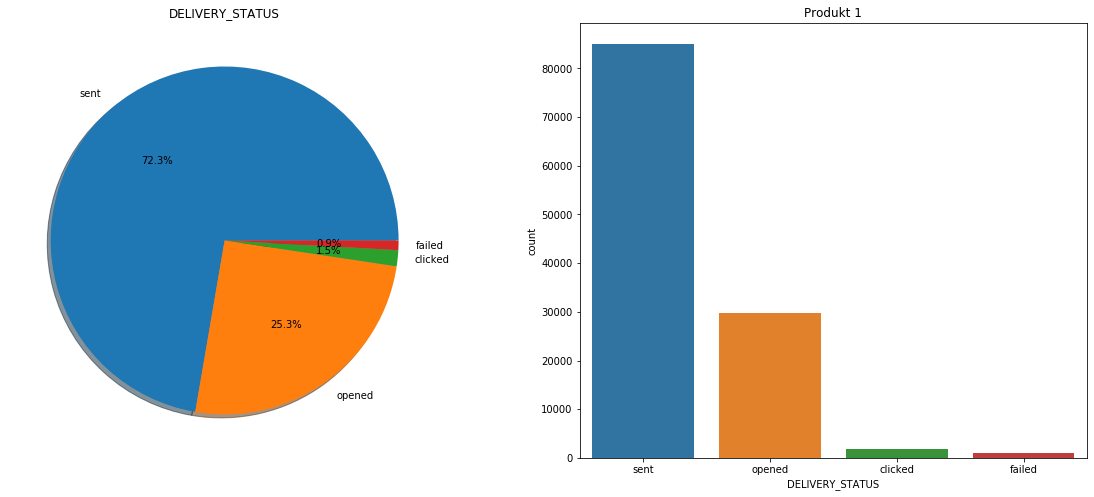

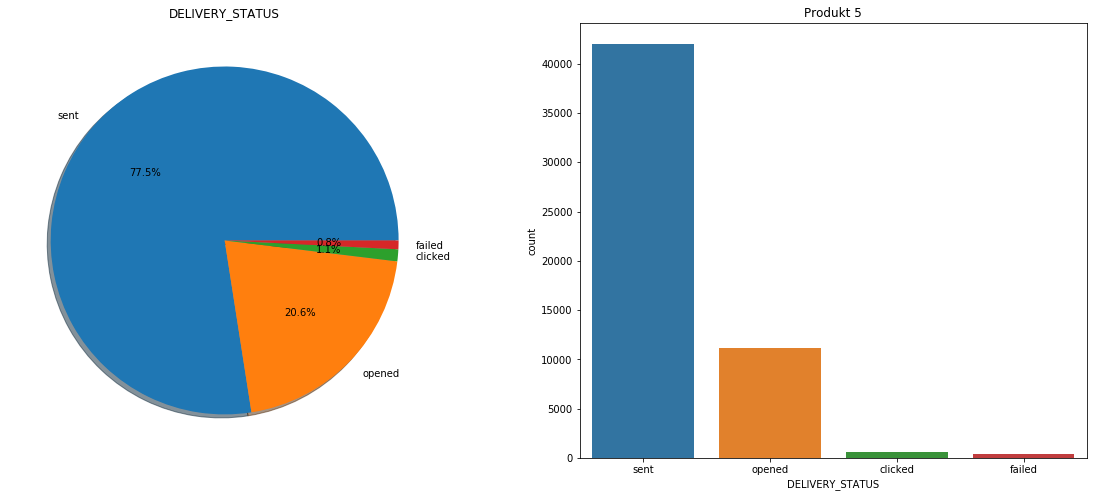

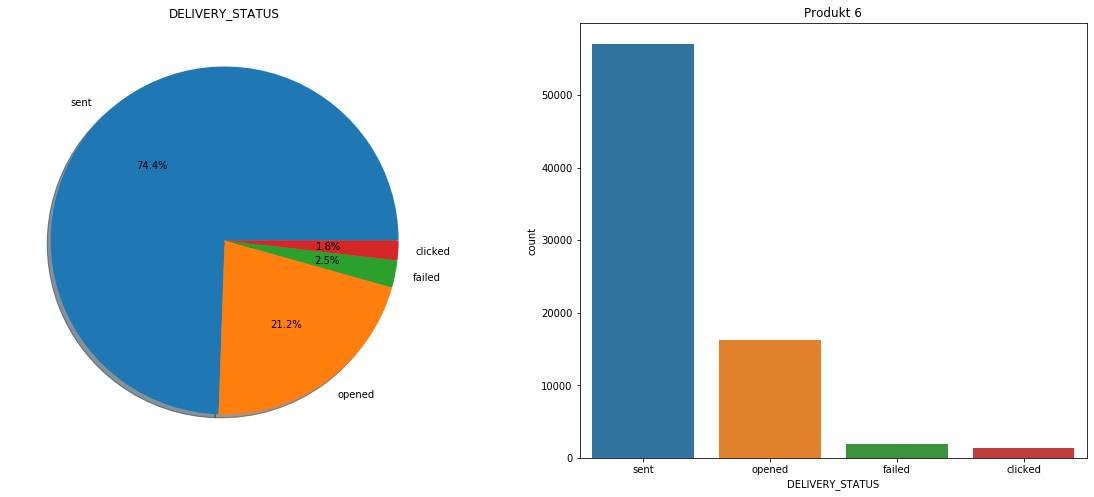

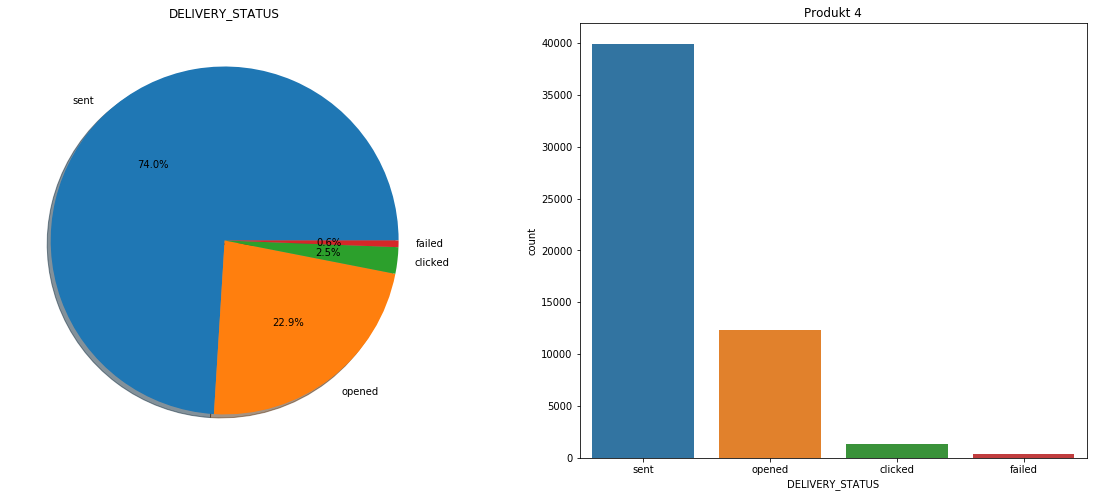

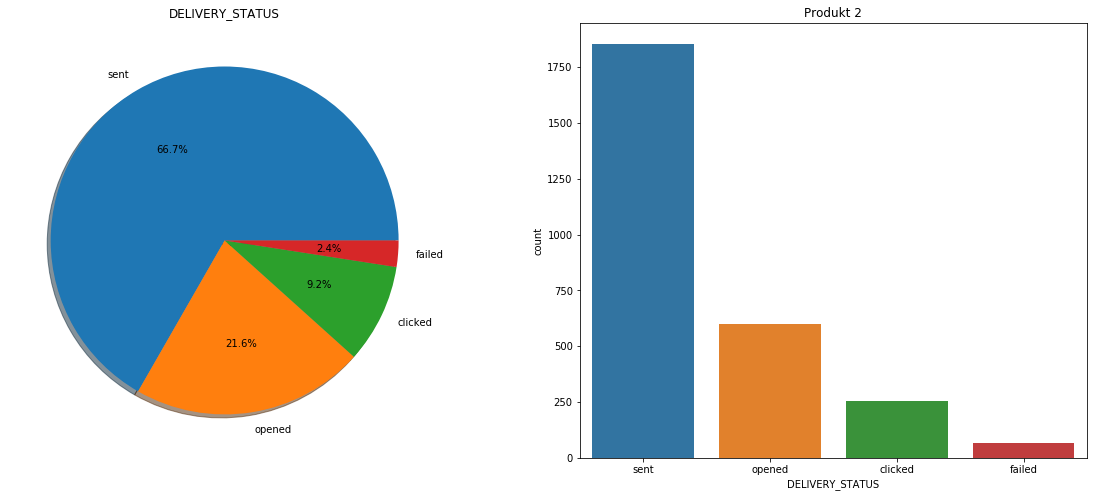

In [184]:
for product in ['Produkt 3', 'Produkt 1', 'Produkt 5', 'Produkt 6', 'Produkt 4', 'Produkt 2']:
    plot_pie_bar(df[df['PRODUKT']==product], 'DELIVERY_STATUS', product)


In [185]:
df.columns


Index(['HCP_ID', 'ACCOUNT_TYPE', 'EMAIL_ID', 'DELIVERY_STATUS', 'PRODUKT',
       'DATUM_ID', 'DAY', 'DATE', 'DATE_TIME', 'TIME', 'TIME_GROUP', 'YEAR',
       'MONTH', 'DAY_OF_WEEK'],
      dtype='object')

In [186]:
def get_nb_dates(row):
    return len(row['set_DATE_TIME'])

group_product = df.groupby(['PRODUKT'])['DATE_TIME'].apply(set).reset_index(name='set_DATE_TIME')

group_product['NB_DATE_TIME'] = group_product.apply(get_nb_dates, axis=1)

group_product.sort_values(by='NB_DATE_TIME', ascending=False, inplace=True)


In [187]:
group_product


,PRODUKT,set_DATE_TIME,NB_DATE_TIME
0,Produkt 1,"{2018-11-02 14:00:00, 2018-04-28 14:00:00, 201...",3621
5,Produkt 6,"{2018-11-02 14:00:00, 2017-11-11 20:00:00, 201...",2972
3,Produkt 4,"{2018-12-20 17:00:00, 2019-03-12 18:00:00, 201...",2101
4,Produkt 5,"{2019-03-12 18:00:00, 2018-12-05 13:00:00, 201...",2070
2,Produkt 3,"{2018-12-20 17:00:00, 2018-12-05 13:00:00, 201...",1926
1,Produkt 2,"{2018-12-01 07:00:00, 2018-12-02 09:00:00, 201...",233


In [188]:
df[df['PRODUKT'] == 'Produkt 2']['DATE_TIME'].min()


Timestamp('2018-11-30 12:00:00')

In [189]:
df[df['PRODUKT'] == 'Produkt 2']['DATE_TIME'].max()


Timestamp('2019-03-22 19:00:00')

In [190]:
df[df['PRODUKT'] == 'Produkt 1']['DATE_TIME'].min()


Timestamp('2017-03-04 09:00:00')

In [192]:
df[df['PRODUKT'] == 'Produkt 1']['DATE_TIME'].max()


Timestamp('2019-03-27 20:00:00')

# Provide recommendations for optimizing the email communication approach including recommendations on how to measure the success of subsequent email campaigns.
